# 1. Filtr Savitzky'ego-Golaya

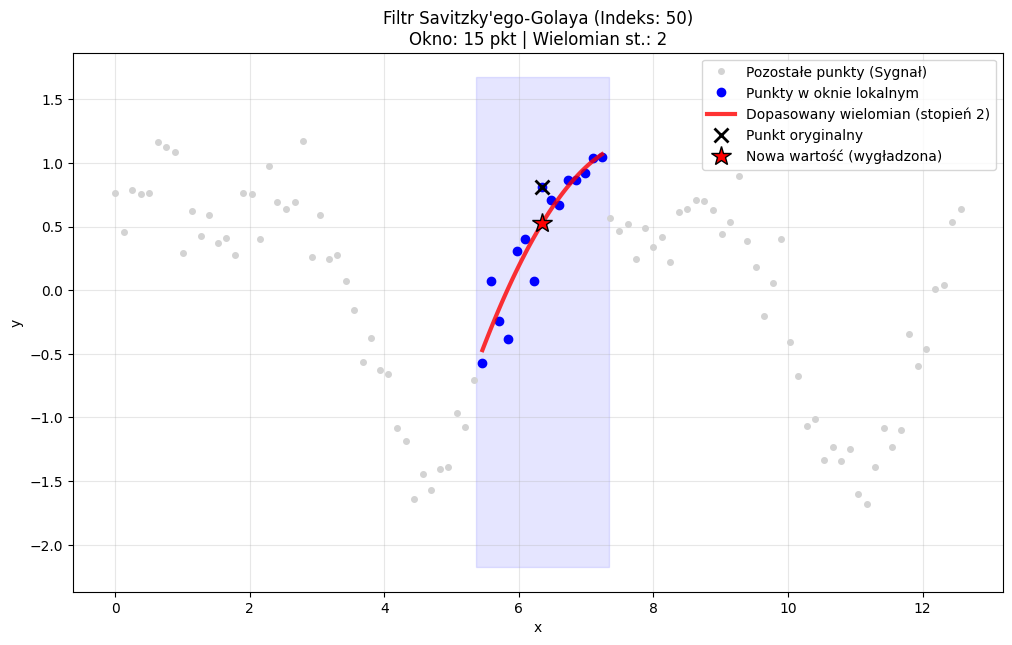

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def generate_noisy_signal(n_points=100):
    x = np.linspace(0, 4*np.pi, n_points)
    y_clean = np.sin(x) + 0.5 * np.cos(2*x)
    noise = np.random.normal(0, 0.2, n_points)
    y_noisy = y_clean + noise
    return x, y_clean, y_noisy

def visualize_savgol_step(x, y_noisy, window_size=15, poly_order=2, frame_idx=50):
    """
    Wizualizuje jeden krok działania filtra:
    1. Wybiera okno wokół punktu.
    2. Dopasowuje wielomian.
    3. Pokazuje wyliczony punkt.
    """
    half_window = window_size // 2
    
    if frame_idx < half_window or frame_idx >= len(x) - half_window:
        print("Wybierz indeks z dala od krawędzi dla jasnej wizualizacji.")
        return

    indices = range(frame_idx - half_window, frame_idx + half_window + 1)
    x_window = x[indices]
    y_window = y_noisy[indices]
    
    coeffs = np.polyfit(x_window, y_window, poly_order)
    poly_func = np.poly1d(coeffs)
    
    x_poly_vis = np.linspace(x_window.min(), x_window.max(), 100)
    y_poly_vis = poly_func(x_poly_vis)
    
    center_x = x[frame_idx]
    center_y_smooth = poly_func(center_x)
    
    plt.figure(figsize=(12, 7))
    
    plt.plot(x, y_noisy, 'o', color='lightgray', markersize=4, label='Pozostałe punkty (Sygnał)')
    
    plt.plot(x_window, y_window, 'o', color='blue', label='Punkty w oknie lokalnym')
    
    plt.plot(x_poly_vis, y_poly_vis, 'r-', linewidth=3, alpha=0.8, 
             label=f'Dopasowany wielomian (stopień {poly_order})')
    
    plt.plot(center_x, y_noisy[frame_idx], 'kx', markersize=10, markeredgewidth=2, label='Punkt oryginalny')
    plt.plot(center_x, center_y_smooth, 'r*', markersize=15, markeredgecolor='black', label='Nowa wartość (wygładzona)')
    
    rect = Rectangle((x_window.min() - 0.1, min(y_noisy) - 0.5), 
                     x_window.max() - x_window.min() + 0.2, 
                     max(y_noisy) - min(y_noisy) + 1, 
                     linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.1)
    plt.gca().add_patch(rect)
    
    plt.title(f"Filtr Savitzky'ego-Golaya (Indeks: {frame_idx})\n"
              f"Okno: {window_size} pkt | Wielomian st.: {poly_order}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

x_data, y_true, y_noise = generate_noisy_signal(n_points=100)

visualize_savgol_step(x_data, y_noise, window_size=15, poly_order=2, frame_idx=50)


## 2. Procesy Gaussowskie

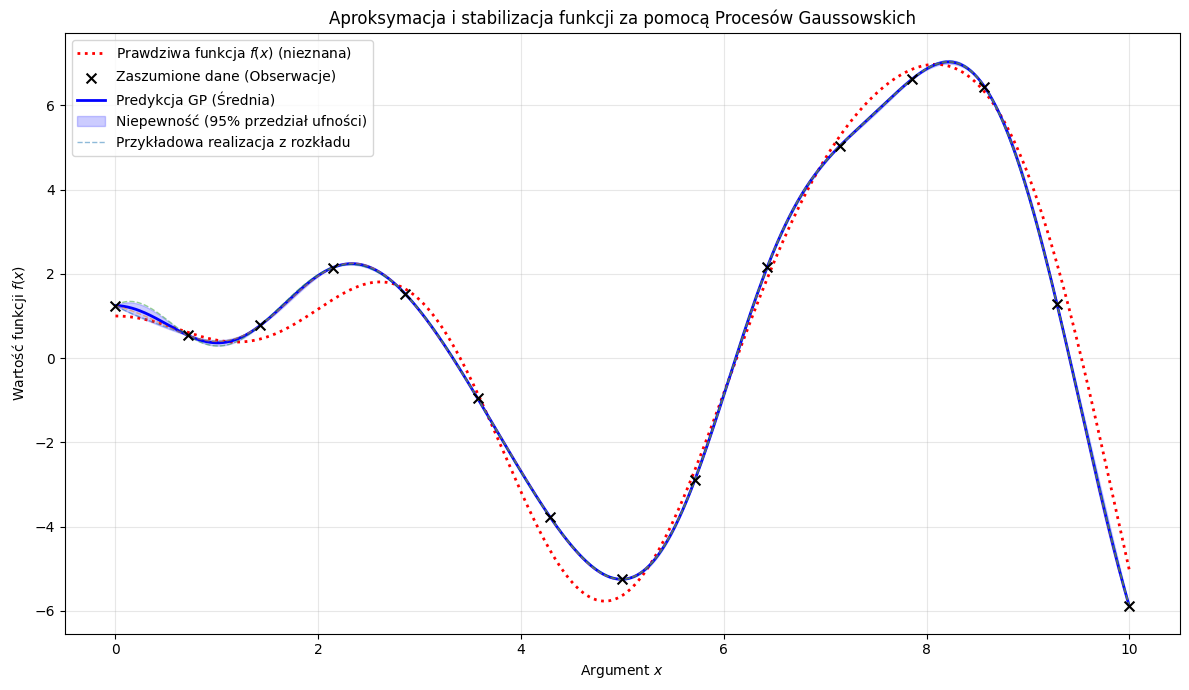

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

np.random.seed(42)

def true_function(x):
    return x * np.sin(x)+np.cos(2*x)

X_train = np.atleast_2d(np.linspace(0, 10, 15)).T
y_train = true_function(X_train).ravel() + np.random.normal(0, 0.5, X_train.shape[0])

x_test = np.atleast_2d(np.linspace(0, 10, 1000)).T


kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
         WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e+1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

y_pred, sigma = gp.predict(x_test, return_std=True)

plt.figure(figsize=(12, 7))

plt.plot(x_test, true_function(x_test), 'r:', linewidth=2, label=r'Prawdziwa funkcja $f(x)$ (nieznana)')

plt.scatter(X_train, y_train, c='k', marker='x', s=50, label='Zaszumione dane (Obserwacje)', zorder=10)

plt.plot(x_test, y_pred, 'b-', linewidth=2, label='Predykcja GP (Średnia)')

plt.fill_between(x_test.ravel(), 
                 y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, 
                 alpha=0.2, color='b', label='Niepewność (95% przedział ufności)')

y_samples = gp.sample_y(x_test, 3)
for idx, single_sample in enumerate(y_samples.T):
    plt.plot(x_test, single_sample, linestyle="--", alpha=0.5, linewidth=1, 
             label=f'Przykładowa realizacja z rozkładu' if idx == 0 else None)

plt.title("Aproksymacja i stabilizacja funkcji za pomocą Procesów Gaussowskich")
plt.xlabel("Argument $x$")
plt.ylabel("Wartość funkcji $f(x)$")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Splajny wygładzające

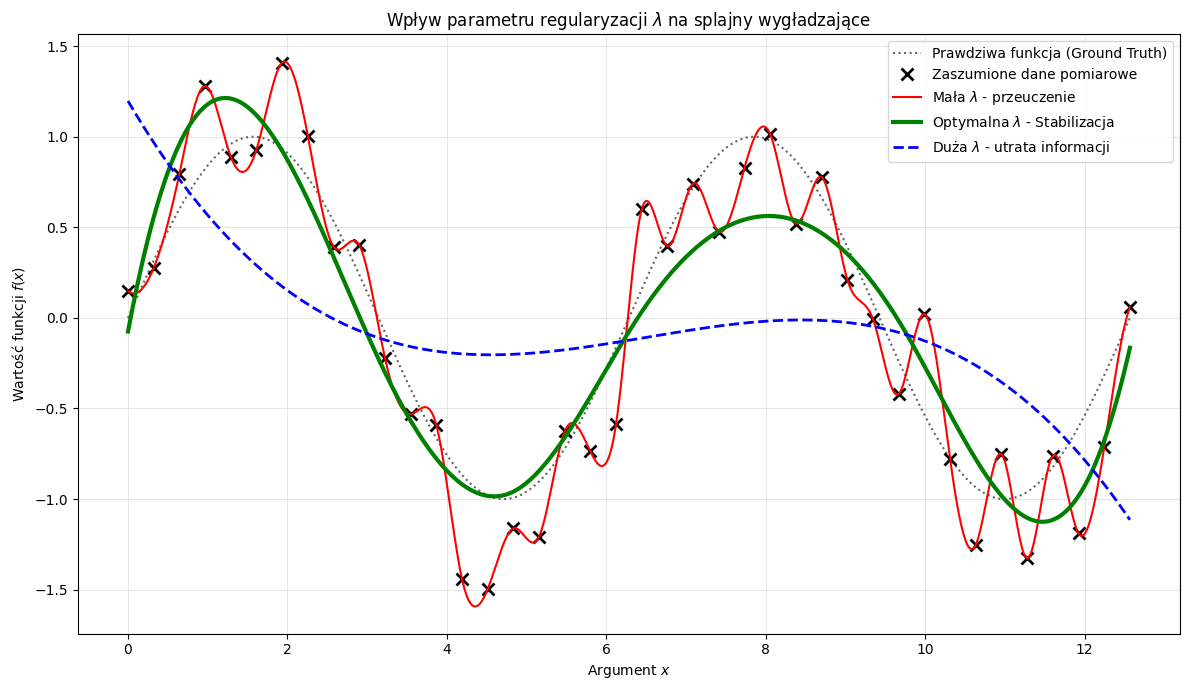

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

np.random.seed(42)
n_points = 40
x = np.linspace(0, 4 * np.pi, n_points)
y_true = np.sin(x)
noise = np.random.normal(0, 0.3, n_points)
y_noisy = y_true + noise

x_plot = np.linspace(min(x), max(x), 1000)


spl_under = UnivariateSpline(x, y_noisy, s=0)

spl_opt = UnivariateSpline(x, y_noisy, s=n_points * 0.3**2)

spl_over = UnivariateSpline(x, y_noisy, s=100) 

plt.figure(figsize=(12, 7))

plt.plot(x_plot, np.sin(x_plot), 'k:', linewidth=1.5, label='Prawdziwa funkcja (Ground Truth)', alpha=0.6)
plt.plot(x, y_noisy, 'kx', markersize=8, markeredgewidth=2, label='Zaszumione dane pomiarowe')

plt.plot(x_plot, spl_under(x_plot), 'r-', linewidth=1.5, 
         label=r'Mała $\lambda$ - przeuczenie')
plt.plot(x_plot, spl_opt(x_plot), 'g-', linewidth=3, 
         label=r'Optymalna $\lambda$ - Stabilizacja')
plt.plot(x_plot, spl_over(x_plot), 'b--', linewidth=2, 
         label=r'Duża $\lambda$ - utrata informacji')

plt.title(r"Wpływ parametru regularyzacji $\lambda$ na splajny wygładzające")
plt.xlabel("Argument $x$")
plt.ylabel("Wartość funkcji $f(x)$")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Autoencoder

Trenowanie modelu...


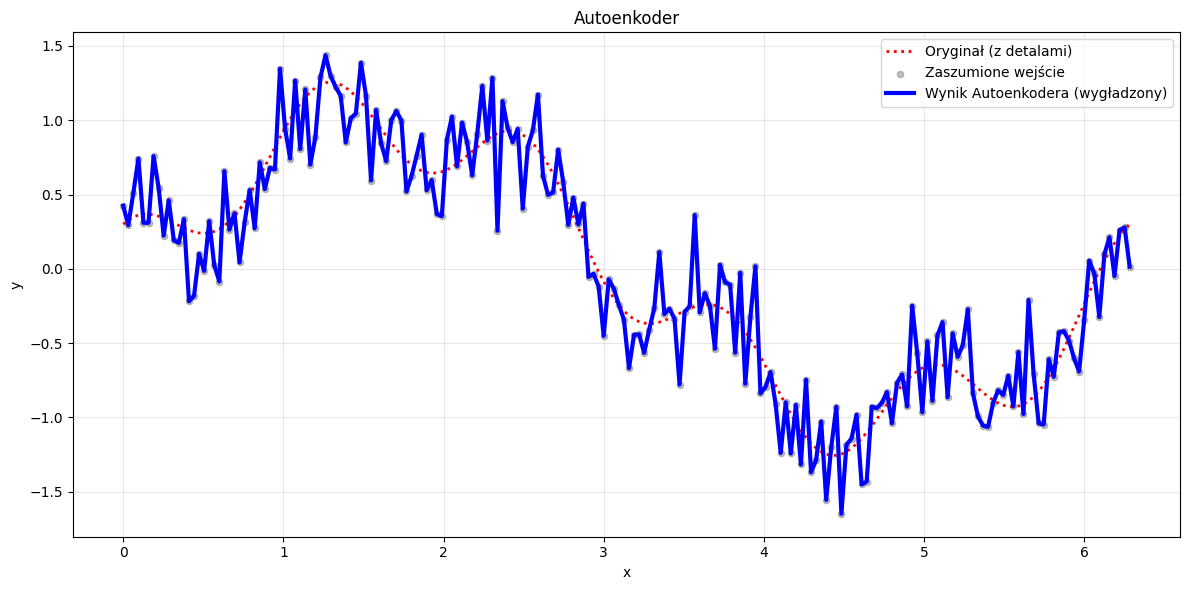

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

def true_function(x):
    return np.sin(x) + 0.3 * np.cos(5 * x)

N_POINTS = 200
X_axis = np.linspace(0, 2*np.pi, N_POINTS)

y_clean = true_function(X_axis)

noise = np.random.normal(0, 0.25, N_POINTS)
y_noisy = y_clean + noise

input_tensor = torch.tensor(y_noisy, dtype=torch.float32).unsqueeze(0)

target_tensor = input_tensor 

class SmoothingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim), 
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = SmoothingAutoencoder(input_dim=N_POINTS, latent_dim=6)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

print("Trenowanie modelu...")
loss_history = []
for epoch in range(3000):
    optimizer.zero_grad()
    output = model(input_tensor)
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

model.eval()
with torch.no_grad():
    y_reconstructed = model(input_tensor).squeeze().numpy()

plt.figure(figsize=(12, 6))

plt.plot(X_axis, y_clean, 'r:', linewidth=2, label='Oryginał (z detalami)', zorder=2)

plt.scatter(X_axis, y_noisy, color='gray', s=20, alpha=0.5, label='Zaszumione wejście', zorder=1)

plt.plot(X_axis, y_reconstructed, 'b-', linewidth=3, label='Wynik Autoenkodera (wygładzony)', zorder=3)

plt.title(f"Autoenkoder")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)

plt.annotate('Model "zgubił"\nte oscylacje', 
             xy=(2.2, 1.8), xytext=(1, 2.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

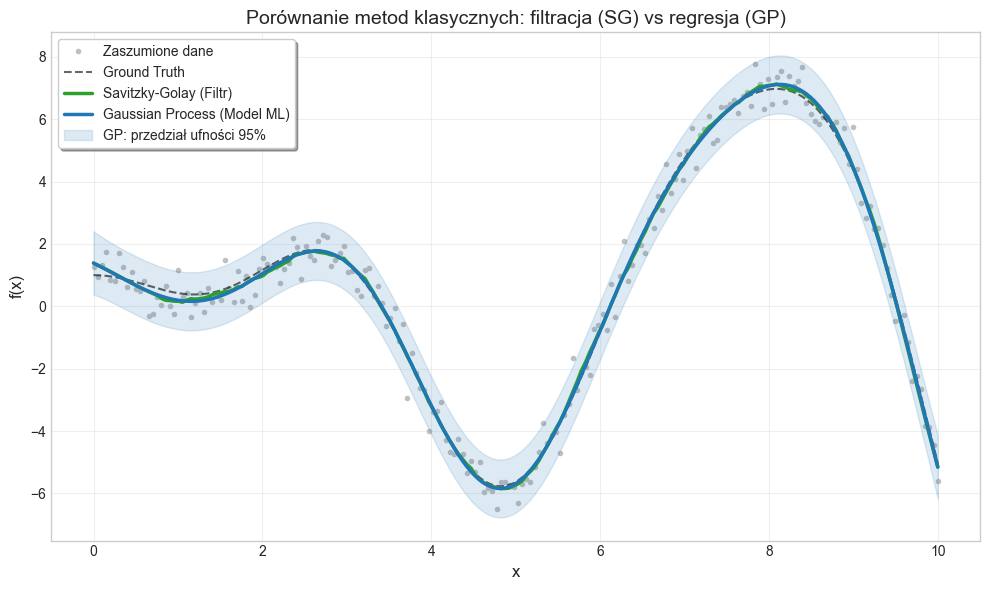

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)


def true_function(x):
    return x * np.sin(x) + np.cos(2 * x)

X = np.linspace(0, 10, 200)
y_true = true_function(X)

# Dodajemy szum
noise = np.random.normal(0, 0.5, size=len(X))
y_noisy = y_true + noise

# Filtr Savitzky-Golay
# Metoda lokalna, szybka, dobra do "wygładzania"
y_sg = savgol_filter(y_noisy, window_length=31, polyorder=3)

# Procesy Gaussowskie (GP)
# Metoda globalna, probabilistyczna, wolniejsza
X_reshaped = X.reshape(-1, 1) 

# Definicja kernela: RBF (gładkość) + WhiteKernel (szum)
kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.2)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gp.fit(X_reshaped, y_noisy)

# Predykcja
y_gp, sigma = gp.predict(X_reshaped, return_std=True)


plt.figure(figsize=(10, 6))

plt.plot(X, y_noisy, '.', color='silver', label='Zaszumione dane', zorder=1)

plt.plot(X, y_true, 'k--', linewidth=1.5, label='Ground Truth', alpha=0.6, zorder=2)

# Wynik Savitzky-Golay
plt.plot(X, y_sg, color='#2ca02c', linewidth=2.5, label='Savitzky-Golay (Filtr)', zorder=3)

# Wynik Gaussian Process
plt.plot(X, y_gp, color='#1f77b4', linewidth=2.5, label='Gaussian Process (Model ML)', zorder=4)

# Niepewność GP 
plt.fill_between(X, y_gp - 1.96*sigma, y_gp + 1.96*sigma, 
                 color='#1f77b4', alpha=0.15, label='GP: przedział ufności 95%')

plt.title("Porównanie metod klasycznych: filtracja (SG) vs regresja (GP)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('assets/classical_methods.png', dpi=300)
plt.show()